# **Preliminary pipeline to calibrate all cameras**

#### The goal of this pipeline is to perform and evaluate the calibration of all cameras for opening track experiments. In order to be able to run it, several prerequisites must be given:

**Synchronized charuco-board recordings:**

Why? Out-of-sync videos can´t be used for calibration, since detected corners of the Charucoboard will be compared across cameras frame by frame. Thus, you must have already synchronized the recordings of the charucoboard with the same fps, e.g. using the `00_synchronize.ipynb` notebook. If not, please synchronize them first! In case any of these videos were cropped, you need to know the cropping indices & whether and how they were flipped.


**Intrinsic camera calibrations:**

In addition to the synchronized Charucoboard recordings to calibrate the cameras to each other, you will also need an intrinsic calibration for each camera. Why? Each camera has a unique distortion of the recorded image that can reduce the calibration quality between multiple cameras. However, you can determine each camera´s unique intrinsic properties & then "invert" these in order to undistort the images. While this can also be done on the Charucoboard recordings within the anipose calibration, it seems to work better using a checkerboard & passing these information along for anipose - especially for a mix of fish-eye and regular cameras. Either option A or option B is required:
- Option A: you have the videos for intrinsic calibration of each camera (uncropped recordings of the checkerboard), then you will have to perform them for each camera
- Option B: these calibrations were already performed and you can simply load the corresponding file for each camera


**Test positions:**

Eventually, you also need some ground truth information to evaluate the calibration. Why? In order to quantify the quality of the calibration, we need some meaningful measurements in addition to the "reprojection error" that anipose returns, which basically tells us the accuracy in units (voxels/pixels?) of the triangulated reference space. Therefore, we triangulate & compute the distances of a certain set of test position markers in the 3D reference space. Since we know the actual distances of these positions, we can compare the measured ground truth distances and the triangulated 3D distances after the calibration & get an error for all distances in cm! For this, you obviously need to know the distances between a certain set of test position markers:
- you either know the distances between certain markers of these test positions, or you can load previously saved test position distances

In addition, you will also need one of the following two options:
- Option A: you have the coordinates of each marker of a test position that is visible in each camera FOV (e.g. from DLC predictions or from tamplate matching)
- Option B: you have images/videos from each camera you would like to calibrate that show the test position markers, then you can manually determine the coordinates of each visible marker id and add it




## Step 1) Create an object that holds the test positions ground truth data:

In [1]:
from gait3d.camera_calibration import TestPositionsGroundTruth
from pathlib import Path

test_positions = TestPositionsGroundTruth()

As mentioned above, you either have the chance to create such an object and feed it with all the distances you measured (and save it to disk, such that you can reuse it the next time), for instance like this:

In [2]:
test_positions.add_new_marker_id(marker_id='screw1_bottom', other_marker_ids_with_distances=[('screw2_bottom', 5),
                                                                                             ('screw1_top', 8.1),
                                                                                             ('screw1_nut', 6.1),
                                                                                             ('screw3_bottom', 7),
                                                                                             ('screw4_bottom', 10)])

In [3]:
test_positions.add_new_marker_id(marker_id='screw1_nut', other_marker_ids_with_distances=[('screw4_top', 10),
                                                                                          ('screw1_top', 2)])

In [4]:
test_positions.add_new_marker_id(marker_id='screw2_bottom', other_marker_ids_with_distances=[('screw3_bottom', 2),
                                                                                             ('screw4_bottom', 5)])

In [5]:
test_positions.add_new_marker_id(marker_id='screw2_top', other_marker_ids_with_distances=[('screw1_top', 7.7),
                                                                                          ('screw3_top', 1.9)])

In [6]:
test_positions.add_new_marker_id(marker_id='screw3_bottom', other_marker_ids_with_distances=[('screw4_bottom', 3)])

In [7]:
test_positions.add_new_marker_id(marker_id='screw3_top', other_marker_ids_with_distances=[('screw4_top', 4.6)])

In [8]:
test_positions.add_new_marker_id(marker_id='screw4_bottom', other_marker_ids_with_distances=[('screw4_top', 6.1)])

In [9]:
test_positions.add_new_marker_id(marker_id='x1', other_marker_ids_with_distances=[('maze_corner_open_left', 9.4),
                                                                                  ('x2', 16.8)])

In [10]:
test_positions.add_new_marker_id(marker_id='x2', other_marker_ids_with_distances=[('maze_corner_closed_left', 17.4)])

You can find a list of all loaded marker ids and their respective distances to other marker ids in the `.marker_ids_with_distances` attribute. Please note, that reciprocal distances are created automatically & that the distances between the maze corners are preloaded already!

In [11]:
test_positions.marker_ids_with_distances

{'maze_corner_open_left': {'maze_corner_open_right': 4,
  'maze_corner_closed_right': 50.15974481593781,
  'maze_corner_closed_left': 50,
  'x1': 9.4},
 'maze_corner_open_right': {'maze_corner_open_left': 4,
  'maze_corner_closed_right': 50,
  'maze_corner_closed_left': 50.15974481593781},
 'maze_corner_closed_right': {'maze_corner_open_left': 50.15974481593781,
  'maze_corner_open_right': 50,
  'maze_corner_closed_left': 4},
 'maze_corner_closed_left': {'maze_corner_open_left': 50,
  'maze_corner_open_right': 50.15974481593781,
  'maze_corner_closed_right': 4,
  'x2': 17.4},
 'screw1_bottom': {'screw2_bottom': 5,
  'screw1_top': 8.1,
  'screw1_nut': 6.1,
  'screw3_bottom': 7,
  'screw4_bottom': 10},
 'screw2_bottom': {'screw1_bottom': 5, 'screw3_bottom': 2, 'screw4_bottom': 5},
 'screw1_top': {'screw1_bottom': 8.1, 'screw1_nut': 2, 'screw2_top': 7.7},
 'screw1_nut': {'screw1_bottom': 6.1, 'screw4_top': 10, 'screw1_top': 2},
 'screw3_bottom': {'screw1_bottom': 7, 'screw2_bottom': 2, 's

In addition, you have to provide at least one distance between two markers, that you would like as reference distance when the triangulated distances are converted to the unit cm. Since the calibration and thus the triangulation performance can (probably will) be different in different regions of the image, it might make sense to provide several reference distances. During the evaluation later on, all of them will be used to convert the triangulated distances to cm & compare them to the ground truth distances you provided above. If these errors are all relatively low, you know that your calibration worked well across the entire recording space! Please note: the reference distances "maze_length_left" (between "maze_corner_open_left" and "maze_corner_closed_left") & "maze_length_right" (same idea) are again pre-loaded and don´t have to be added:

In [12]:
test_positions.add_marker_ids_and_distance_id_as_reference_distance(marker_ids=('screw1_bottom', 'screw4_bottom'), distance_id='screw_1-4_bottoms')

In [13]:
test_positions.reference_distance_ids_with_corresponding_marker_ids

[('maze_length_left', 'maze_corner_open_left', 'maze_corner_closed_left'),
 ('maze_length_right', 'maze_corner_open_right', 'maze_corner_closed_right'),
 ('screw_1-4_bottoms', 'screw1_bottom', 'screw4_bottom')]

Finally, if you´d like to have a certain set of marker ids connected in the 3D plot of the triangulation space, feel free to add them like this. Please note, the maze corners will be added automatically again:

In [14]:
test_positions.add_marker_ids_to_be_connected_in_3d_plots(marker_ids=('screw1_bottom', 'screw4_bottom', 'screw4_top', 'screw1_nut'))

In [15]:
test_positions.marker_ids_to_connect_in_3D_plot

[('maze_corner_open_left',
  'maze_corner_open_right',
  'maze_corner_closed_right',
  'maze_corner_closed_left'),
 ('screw1_bottom', 'screw4_bottom', 'screw4_top', 'screw1_nut')]

Alright, that´s it! Of course, please add as many marker ids, distances, reference distances & marker id combinations to be connected as you´d like! If you are happy with your `TestPositionsGroundTruth` object, you can save it to disk. Please note, this currently does not save the reference distances or the marker ids you´d like to connect, but solely the marker ids and the distances between them.

In [16]:
filepath = Path('/mnt/c/Users/dsege/Downloads/220825/220825/test_positions_ground_truth.p')
test_positions.save_to_disk(filepath = filepath)

Well, alternatively, if all these information have already been saved, you can of course simply load them. Please be aware, that only the default reference distances ("maze_length_left" and "maze_length_right") and the default marker ids to connect (all maze corners) will be loaded - however, of course all the marker ids & distances between them are also included:

In [4]:
test_positions_loaded = TestPositionsGroundTruth()
filepath = Path('/mnt/c/Users/dsege/Downloads/220825/220825/test_positions_ground_truth.p')
test_positions_loaded.load_from_disk(filepath = filepath)

In [5]:
test_positions_loaded.reference_distance_ids_with_corresponding_marker_ids

[('maze_length_left', 'maze_corner_open_left', 'maze_corner_closed_left'),
 ('maze_length_right', 'maze_corner_open_right', 'maze_corner_closed_right')]

In [6]:
test_positions_loaded.marker_ids_to_connect_in_3D_plot

[('maze_corner_open_left',
  'maze_corner_open_right',
  'maze_corner_closed_right',
  'maze_corner_closed_left')]

In [7]:
test_positions_loaded.marker_ids_with_distances

{'maze_corner_open_left': {'maze_corner_open_right': 4,
  'maze_corner_closed_right': 50.15974481593781,
  'maze_corner_closed_left': 50,
  'x1': 9.4},
 'maze_corner_open_right': {'maze_corner_open_left': 4,
  'maze_corner_closed_right': 50,
  'maze_corner_closed_left': 50.15974481593781},
 'maze_corner_closed_right': {'maze_corner_open_left': 50.15974481593781,
  'maze_corner_open_right': 50,
  'maze_corner_closed_left': 4},
 'maze_corner_closed_left': {'maze_corner_open_left': 50,
  'maze_corner_open_right': 50.15974481593781,
  'maze_corner_closed_right': 4,
  'x2': 17.4},
 'screw1_bottom': {'screw2_bottom': 5,
  'screw1_top': 8.1,
  'screw1_nut': 6.1,
  'screw3_bottom': 7,
  'screw4_bottom': 10},
 'screw2_bottom': {'screw1_bottom': 5, 'screw3_bottom': 2, 'screw4_bottom': 5},
 'screw1_top': {'screw1_bottom': 8.1, 'screw1_nut': 2, 'screw2_top': 7.7},
 'screw1_nut': {'screw1_bottom': 6.1, 'screw4_top': 10, 'screw1_top': 2},
 'screw3_bottom': {'screw1_bottom': 7, 'screw2_bottom': 2, 's

## Step 2) Prepare the data for each single camera you´d like to include in the calibration / triangulation:

The following steps have to be performed for each camera individually, such that you end up with as many `SingleCamDataForAnipose` objects, as you have cameras. Of course, you can adapt the input for each camera individually! Let´s go through the process for the top cam. First, we initialize the object with a unique cam ID and the filepath of the synchronized calibration video that is to be used for the calibration between the set of cameras:

In [17]:
from gait3d.camera_calibration import SingleCamDataForAnipose
from pathlib import Path
import os

### Top cam:

In [18]:
filepath = Path('/mnt/c/Users/dsege/Downloads/220825/220825/220825_Top_Charuco001.AVI')
top_cam = SingleCamDataForAnipose(cam_id = 'Top', filepath_synchronized_calibration_video = filepath)

Next, it makes sense to add all additional metadata about your camera, like the offset of the cropping indices that you noted during cropping in ICCapture & whether and how the video stream was flipped. If you did neither crop the video nor flip it, you can simply skip these functions and the default values (offsets = (0, 0) and both flippings = False) will be loaded automatically.

In [19]:
top_cam.add_cropping_offsets(x_or_column_offset=0, y_or_row_offset=0)
top_cam.add_flipping_details(flipped_horizontally=False, flipped_vertically=False)

Let´s stay with the properties of the camera also for the next step: the intrinsic camera calibration (see some explanation of what this is and why it is neccessary at the very top of this notebook). You can either run it (see the following cell - don´t worry, the calibration results will automatically be saved in the same directory where the checkerboard video is) ...

In [20]:
#filepath_checkerboard_recording = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Checkerboard_Calibration/Top_checkerboard.AVI')
#top_cam.run_intrinsic_camera_calibration(filepath_checkerboard_video=filepath_checkerboard_recording)

... or load it from disk, if you have previously performed the calibration already:

In [20]:
intrinsic_calibrations_dir = Path(os.getcwd()).joinpath('intrinsic_camera_calibrations')

In [22]:
filepath_intrinsic_calibration = intrinsic_calibrations_dir.joinpath('Top_checkerboard_intrinsic_calibration_results.p')
top_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = filepath_intrinsic_calibration)

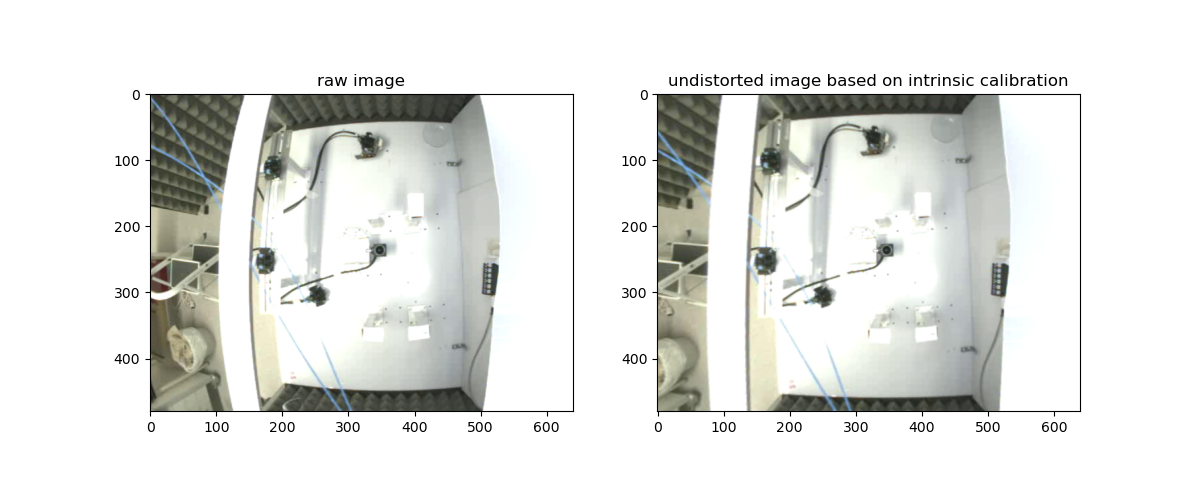

In [23]:
%matplotlib widget
top_cam.inspect_intrinsic_calibration()

Great! All relevant metadata are now loaded and stored in the `SingleCamDataForAnipose` object & we will have them readily with us, wherever we move the object - eventually, this will be to the anipose calibration. But before we get there, we have some more work to do. We need to also add the information to our object, which markers of the test positions it can see & where they are in the image. This can be either done automatically (to be implemented / trained) - or manually. For this, we will load the test positions image (or the first frame of the positions video in case of the top cam) from the corresponding camera and manually determine & load the marker ids & their pixel coordinates: 

In [25]:
from gait3d.utils import plot_image, plot_single_frame_of_video
import matplotlib.pyplot as plt

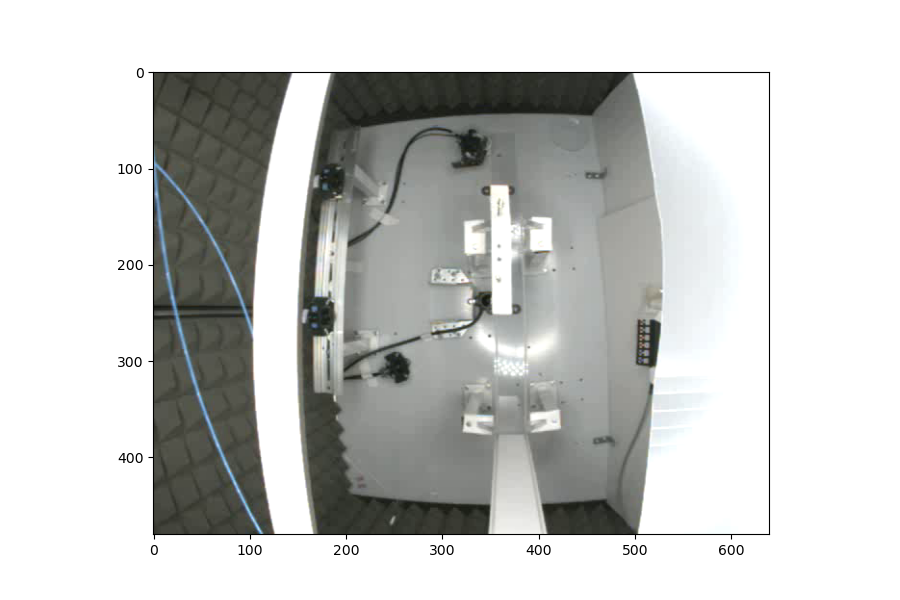

In [26]:
plt.close()
plot_single_frame_of_video(filepath='/mnt/c/Users/dsege/Downloads/220825/220825/220825_Top_Positions002.AVI', frame_idx=0)

In [27]:
top_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 360 , y_or_row_idx = 375, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_right', x_or_column_idx = 383 , y_or_row_idx = 375, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'maze_corner_open_left', x_or_column_idx = 351 , y_or_row_idx = 63, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'maze_corner_open_right', x_or_column_idx = 374 , y_or_row_idx = 63, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'screw1_top', x_or_column_idx = 360, y_or_row_idx = 132, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'screw1_nut', x_or_column_idx = 358, y_or_row_idx = 136, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'screw2_top', x_or_column_idx = 359, y_or_row_idx = 180, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'screw3_top', x_or_column_idx = 360, y_or_row_idx = 194, likelihood=0.999)
top_cam.add_manual_test_position_marker(marker_id = 'screw4_top', x_or_column_idx = 360, y_or_row_idx = 216, likelihood=0.999)

In order to save them & also bring them into the correct DataFrame format, run: 

In [30]:
top_cam.save_manual_marker_coords_as_fake_dlc_output()

Your dataframe was successfully saved at: /mnt/c/Users/dsege/Downloads/220825/220825/Top_manual_test_position_marker_fake.h5.
Your "fake DLC marker perdictions" were successfully loaded to the SingleCamDataForAnipose object!


In [31]:
top_cam.test_position_markers_df

scorer    manually_annotated_marker_positions                  \
bodyparts             maze_corner_closed_left                   
coords                                      x    y likelihood   
0                                         360  375      0.999   

scorer                                                                        \
bodyparts maze_corner_closed_right                 maze_corner_open_left       
coords                           x    y likelihood                     x   y   
0                              383  375      0.999                   351  63   

scorer                                       ...                             \
bodyparts            maze_corner_open_right  ... screw1_nut screw2_top        
coords    likelihood                      x  ... likelihood          x    y   
0              0.999                    374  ...      0.999        359  180   

scorer                                                                      
bodyparts            screw3_top                 screw4_top                  
coords    likelihood          x    y likelihood          x    y likelihood  
0              0.999        360  194      0.999        360  216      0.999  

[1 rows x 27 columns]

Most likely, you will not be able to see all the test position markers from the individual camera FOV. Simply add those that you can see & eventually run the following method to validate them, which: a) adds those markers that are present in the test positions ground truth object but are missing in your current camera object with a likelihood of 0; and b) removes all marker ids that you added to your camera object, but are not present in the ground truth (to avoid typos, ..). Of course, you will be notified:

In [32]:
top_cam.validate_test_position_marker_ids(test_positions_gt=test_positions)

The following marker_ids were missing and added to the dataframe with a likelihood of 0: ['screw1_bottom', 'screw2_bottom', 'screw3_bottom', 'screw4_bottom', 'x1', 'x2'].


In [33]:
top_cam.test_position_markers_df

scorer    manually_annotated_marker_positions                  \
bodyparts             maze_corner_closed_left                   
coords                                      x    y likelihood   
0                                         360  375      0.999   

scorer                                                                        \
bodyparts maze_corner_closed_right                 maze_corner_open_left       
coords                           x    y likelihood                     x   y   
0                              383  375      0.999                   351  63   

scorer                                       ...                              \
bodyparts            maze_corner_open_right  ... screw3_bottom screw4_bottom   
coords    likelihood                      x  ...    likelihood             x   
0              0.999                    374  ...             0             0   

scorer                                                     
bodyparts               x1               x2                
coords     y likelihood  x  y likelihood  x  y likelihood  
0          0          0  0  0          0  0  0          0  

[1 rows x 45 columns]

Now we have to repeat this for all individual cameras:


..:

### Bottom cam:

In [34]:
filepath = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Bottom_cam_synchronized_for_calibration_all_parts.mp4')
bottom_cam = SingleCamDataForAnipose(cam_id = 'Bottom', filepath_synchronized_calibration_video = filepath, fisheye = True)

Next, it makes sense to add all additional metadata about your camera, like the offset of the cropping indices that you noted during cropping in ICCapture & whether and how the video stream was flipped. If you did neither crop the video nor flip it, you can simply skip these functions and the default values (offsets = (0, 0) and both flippings = False) will be loaded automatically.

In [35]:
bottom_cam.add_cropping_offsets(x_or_column_offset=136, y_or_row_offset=452)
bottom_cam.add_flipping_details(flipped_horizontally=False, flipped_vertically=False)

Let´s stay with the properties of the camera also for the next step: the intrinsic camera calibration (see some explanation of what this is and why it is neccessary at the very top of this notebook). You can either run it (see the following cell - don´t worry, the calibration results will automatically be saved in the same directory where the checkerboard video is) ...

In [36]:
#filepath_checkerboard_recording = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Checkerboard_Calibration/Bottom_checkerboard.mp4')
#bottom_cam.run_intrinsic_camera_calibration(filepath_checkerboard_video=filepath_checkerboard_recording)

In [37]:
filepath_intrinsic_calibration = intrinsic_calibrations_dir.joinpath('Bottom_checkerboard_intrinsic_calibration_results.p')
bottom_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = filepath_intrinsic_calibration)

User info: since no other information were provided, "degrees_rotated_clockwise" were set to the corresponding default values: 0.


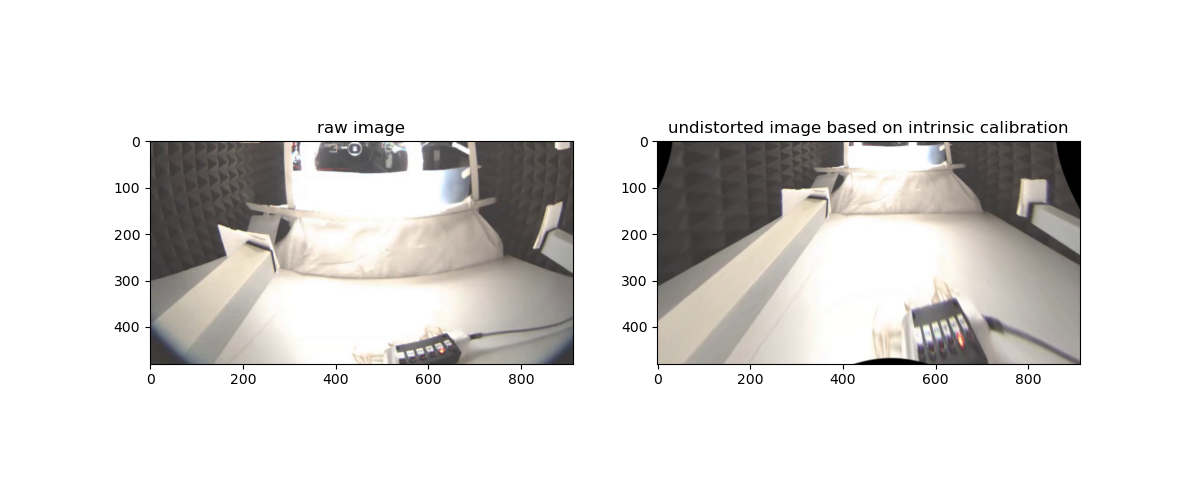

In [38]:
plt.close()
bottom_cam.inspect_intrinsic_calibration()

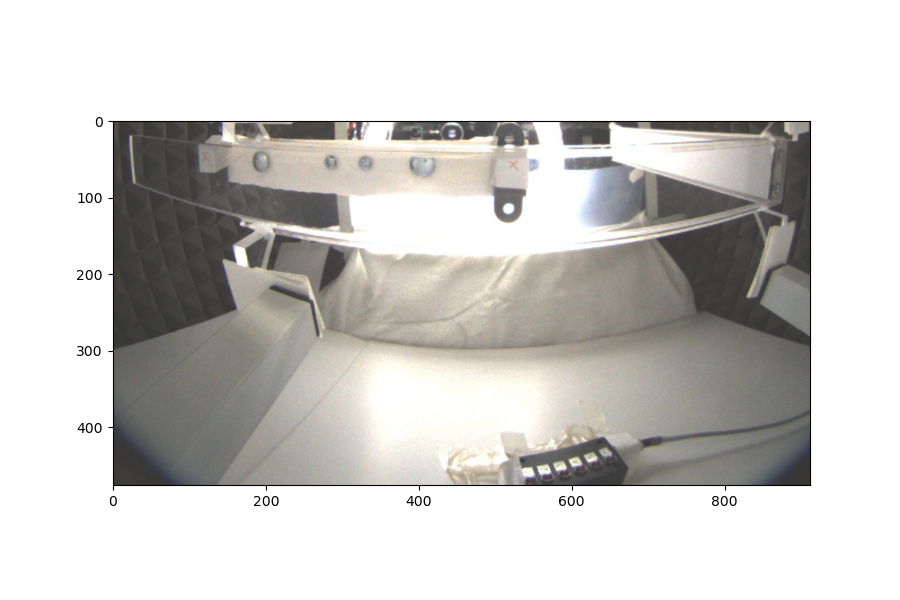

In [39]:
plt.close()
plot_single_frame_of_video(filepath='/mnt/c/Users/dsege/Downloads/220825/220825/220825_Bottom_Positions.jpg', frame_idx=0)

In [40]:
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 859, y_or_row_idx = 30, likelihood=0.999)
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_right', x_or_column_idx = 857, y_or_row_idx = 102, likelihood=0.999)
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_open_left', x_or_column_idx = 24, y_or_row_idx = 18, likelihood=0.999)
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_open_right', x_or_column_idx = 28, y_or_row_idx = 80, likelihood=0.999)
bottom_cam.add_manual_test_position_marker(marker_id = 'x1', x_or_column_idx = 121, y_or_row_idx = 27, likelihood=0.999)
bottom_cam.add_manual_test_position_marker(marker_id = 'x2', x_or_column_idx = 522, y_or_row_idx = 34, likelihood=0.999)
bottom_cam.add_manual_test_position_marker(marker_id = 'screw1_bottom', x_or_column_idx = 191, y_or_row_idx = 42, likelihood=0.999)
bottom_cam.add_manual_test_position_marker(marker_id = 'screw2_bottom', x_or_column_idx = 281, y_or_row_idx = 46, likelihood=0.999)
bottom_cam.add_manual_test_position_marker(marker_id = 'screw3_bottom', x_or_column_idx = 330, y_or_row_idx = 47, likelihood=0.999)
bottom_cam.add_manual_test_position_marker(marker_id = 'screw4_bottom', x_or_column_idx = 403, y_or_row_idx = 42, likelihood=0.999)

In [41]:
bottom_cam.save_manual_marker_coords_as_fake_dlc_output()

Your dataframe was successfully saved at: /mnt/c/Users/dsege/Downloads/220825/220825/Bottom_manual_test_position_marker_fake.h5.
Your "fake DLC marker perdictions" were successfully loaded to the SingleCamDataForAnipose object!


In [42]:
bottom_cam.test_position_markers_df

scorer    manually_annotated_marker_positions                 \
bodyparts             maze_corner_closed_left                  
coords                                      x   y likelihood   
0                                         859  30      0.999   

scorer                                                                        \
bodyparts maze_corner_closed_right                 maze_corner_open_left       
coords                           x    y likelihood                     x   y   
0                              857  102      0.999                    24  18   

scorer                                       ...                              \
bodyparts            maze_corner_open_right  ... screw1_bottom screw2_bottom   
coords    likelihood                      x  ...    likelihood             x   
0              0.999                     28  ...         0.999           281   

scorer                                                                   \
bodyparts                screw3_bottom                screw4_bottom       
coords      y likelihood             x   y likelihood             x   y   
0          46      0.999           330  47      0.999           403  42   

scorer                
bodyparts             
coords    likelihood  
0              0.999  

[1 rows x 30 columns]

Most likely, you will not be able to see all the test position markers from the individual camera FOV. Simply add those that you can see & eventually run the following method to validate them, which: a) adds those markers that are present in the test positions ground truth object but are missing in your current camera object with a likelihood of 0; and b) removes all marker ids that you added to your camera object, but are not present in the ground truth (to avoid typos, ..). Of course, you will be notified:

In [43]:
bottom_cam.validate_test_position_marker_ids(test_positions_gt=test_positions)

The following marker_ids were missing and added to the dataframe with a likelihood of 0: ['screw1_top', 'screw1_nut', 'screw4_top', 'screw2_top', 'screw3_top'].


In [44]:
bottom_cam.test_position_markers_df

scorer    manually_annotated_marker_positions                 \
bodyparts             maze_corner_closed_left                  
coords                                      x   y likelihood   
0                                         859  30      0.999   

scorer                                                                        \
bodyparts maze_corner_closed_right                 maze_corner_open_left       
coords                           x    y likelihood                     x   y   
0                              857  102      0.999                    24  18   

scorer                                       ...                           \
bodyparts            maze_corner_open_right  ... screw1_nut screw4_top      
coords    likelihood                      x  ... likelihood          x  y   
0              0.999                     28  ...          0          0  0   

scorer                                                                  
bodyparts            screw2_top               screw3_top                
coords    likelihood          x  y likelihood          x  y likelihood  
0                  0          0  0          0          0  0          0  

[1 rows x 45 columns]

### Side1 cam:

In [45]:
filepath = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Side1_cam_synchronized_for_calibration_all_parts.mp4')
side1_cam = SingleCamDataForAnipose(cam_id = 'Side1', filepath_synchronized_calibration_video = filepath)

Next, it makes sense to add all additional metadata about your camera, like the offset of the cropping indices that you noted during cropping in ICCapture & whether and how the video stream was flipped. If you did neither crop the video nor flip it, you can simply skip these functions and the default values (offsets = (0, 0) and both flippings = False) will be loaded automatically.

In [46]:
side1_cam.add_cropping_offsets(x_or_column_offset=84, y_or_row_offset=132)
side1_cam.add_flipping_details(flipped_horizontally=True, flipped_vertically=True)

Let´s stay with the properties of the camera also for the next step: the intrinsic camera calibration (see some explanation of what this is and why it is neccessary at the very top of this notebook). You can either run it (see the following cell - don´t worry, the calibration results will automatically be saved in the same directory where the checkerboard video is) ...

In [47]:
#filepath_checkerboard_recording = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Checkerboard_Calibration/Side1_checkerboard.mp4')
#side1_cam.run_intrinsic_camera_calibration(filepath_checkerboard_video=filepath_checkerboard_recording)

... or load it from disk, if you have previously performed the calibration already:

In [48]:
filepath_intrinsic_calibration = intrinsic_calibrations_dir.joinpath('Side1_checkerboard_intrinsic_calibration_results.p')
side1_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = filepath_intrinsic_calibration)

User info: since no other information were provided, "degrees_rotated_clockwise" were set to the corresponding default values: 0.


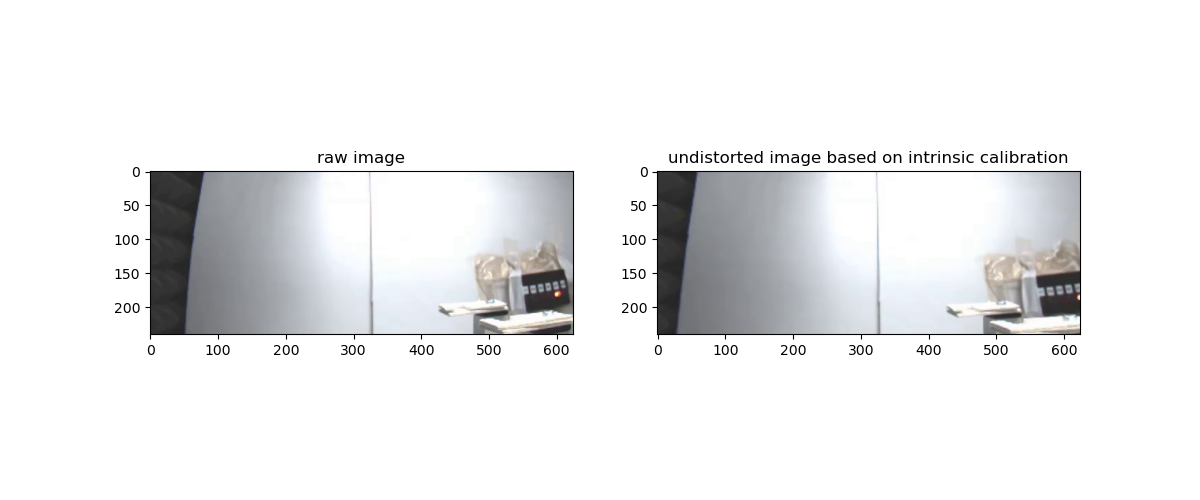

In [49]:
plt.close()
side1_cam.inspect_intrinsic_calibration()

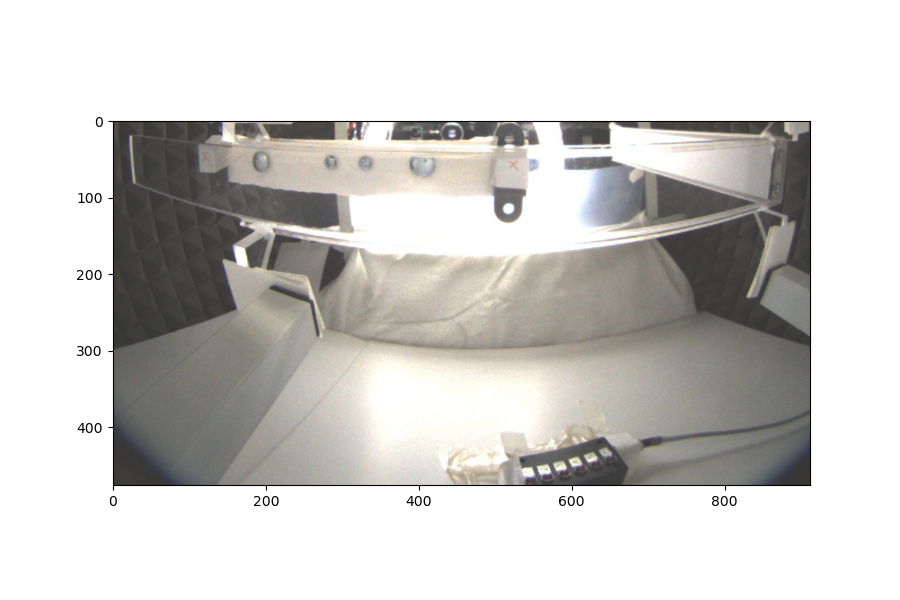

In [39]:
plt.close()
plot_single_frame_of_video(filepath='/mnt/c/Users/dsege/Downloads/220825/220825/220825_', frame_idx=0)

In [40]:
side1_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 859, y_or_row_idx = 30, likelihood=0.999)
side1_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_right', x_or_column_idx = 857, y_or_row_idx = 102, likelihood=0.999)
side1_cam.add_manual_test_position_marker(marker_id = 'maze_corner_open_left', x_or_column_idx = 24, y_or_row_idx = 18, likelihood=0.999)
side1_cam.add_manual_test_position_marker(marker_id = 'maze_corner_open_right', x_or_column_idx = 28, y_or_row_idx = 80, likelihood=0.999)
side1_cam.add_manual_test_position_marker(marker_id = 'x1', x_or_column_idx = 121, y_or_row_idx = 27, likelihood=0.999)
side1_cam.add_manual_test_position_marker(marker_id = 'x2', x_or_column_idx = 522, y_or_row_idx = 34, likelihood=0.999)
side1_cam.add_manual_test_position_marker(marker_id = 'screw1_bottom', x_or_column_idx = 191, y_or_row_idx = 42, likelihood=0.999)
side1_cam.add_manual_test_position_marker(marker_id = 'screw2_bottom', x_or_column_idx = 281, y_or_row_idx = 46, likelihood=0.999)
side1_cam.add_manual_test_position_marker(marker_id = 'screw3_bottom', x_or_column_idx = 330, y_or_row_idx = 47, likelihood=0.999)
side1_cam.add_manual_test_position_marker(marker_id = 'screw4_bottom', x_or_column_idx = 403, y_or_row_idx = 42, likelihood=0.999)

In [41]:
side1_cam.save_manual_marker_coords_as_fake_dlc_output()

Your dataframe was successfully saved at: /mnt/c/Users/dsege/Downloads/220825/220825/Bottom_manual_test_position_marker_fake.h5.
Your "fake DLC marker perdictions" were successfully loaded to the SingleCamDataForAnipose object!


In [42]:
side1_cam.test_position_markers_df

scorer    manually_annotated_marker_positions                 \
bodyparts             maze_corner_closed_left                  
coords                                      x   y likelihood   
0                                         859  30      0.999   

scorer                                                                        \
bodyparts maze_corner_closed_right                 maze_corner_open_left       
coords                           x    y likelihood                     x   y   
0                              857  102      0.999                    24  18   

scorer                                       ...                              \
bodyparts            maze_corner_open_right  ... screw1_bottom screw2_bottom   
coords    likelihood                      x  ...    likelihood             x   
0              0.999                     28  ...         0.999           281   

scorer                                                                   \
bodyparts                screw3_bottom                screw4_bottom       
coords      y likelihood             x   y likelihood             x   y   
0          46      0.999           330  47      0.999           403  42   

scorer                
bodyparts             
coords    likelihood  
0              0.999  

[1 rows x 30 columns]

Most likely, you will not be able to see all the test position markers from the individual camera FOV. Simply add those that you can see & eventually run the following method to validate them, which: a) adds those markers that are present in the test positions ground truth object but are missing in your current camera object with a likelihood of 0; and b) removes all marker ids that you added to your camera object, but are not present in the ground truth (to avoid typos, ..). Of course, you will be notified:

In [43]:
side1_cam.validate_test_position_marker_ids(test_positions_gt=test_positions)

The following marker_ids were missing and added to the dataframe with a likelihood of 0: ['screw1_top', 'screw1_nut', 'screw4_top', 'screw2_top', 'screw3_top'].


In [44]:
side1_cam.test_position_markers_df

scorer    manually_annotated_marker_positions                 \
bodyparts             maze_corner_closed_left                  
coords                                      x   y likelihood   
0                                         859  30      0.999   

scorer                                                                        \
bodyparts maze_corner_closed_right                 maze_corner_open_left       
coords                           x    y likelihood                     x   y   
0                              857  102      0.999                    24  18   

scorer                                       ...                           \
bodyparts            maze_corner_open_right  ... screw1_nut screw4_top      
coords    likelihood                      x  ... likelihood          x  y   
0              0.999                     28  ...          0          0  0   

scorer                                                                  
bodyparts            screw2_top               screw3_top                
coords    likelihood          x  y likelihood          x  y likelihood  
0                  0          0  0          0          0  0          0  

[1 rows x 45 columns]

### Side2 cam:

In [50]:
filepath = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Side2_cam_synchronized_for_calibration_all_parts.mp4')
side2_cam = SingleCamDataForAnipose(cam_id = 'Side2', filepath_synchronized_calibration_video = filepath)

Next, it makes sense to add all additional metadata about your camera, like the offset of the cropping indices that you noted during cropping in ICCapture & whether and how the video stream was flipped. If you did neither crop the video nor flip it, you can simply skip these functions and the default values (offsets = (0, 0) and both flippings = False) will be loaded automatically.

In [51]:
side2_cam.add_cropping_offsets(x_or_column_offset=104, y_or_row_offset=156)
side2_cam.add_flipping_details(flipped_horizontally=True, flipped_vertically=True)

Let´s stay with the properties of the camera also for the next step: the intrinsic camera calibration (see some explanation of what this is and why it is neccessary at the very top of this notebook). You can either run it (see the following cell - don´t worry, the calibration results will automatically be saved in the same directory where the checkerboard video is) ...

In [52]:
#filepath_checkerboard_recording = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Checkerboard_Calibration/Side2_checkerboard.mp4')
#side2_cam.run_intrinsic_camera_calibration(filepath_checkerboard_video=filepath_checkerboard_recording)

... or load it from disk, if you have previously performed the calibration already:

In [53]:
filepath_intrinsic_calibration = intrinsic_calibrations_dir.joinpath('Side2_checkerboard_intrinsic_calibration_results.p')
side2_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = filepath_intrinsic_calibration)

User info: since no other information were provided, "degrees_rotated_clockwise" were set to the corresponding default values: 0.


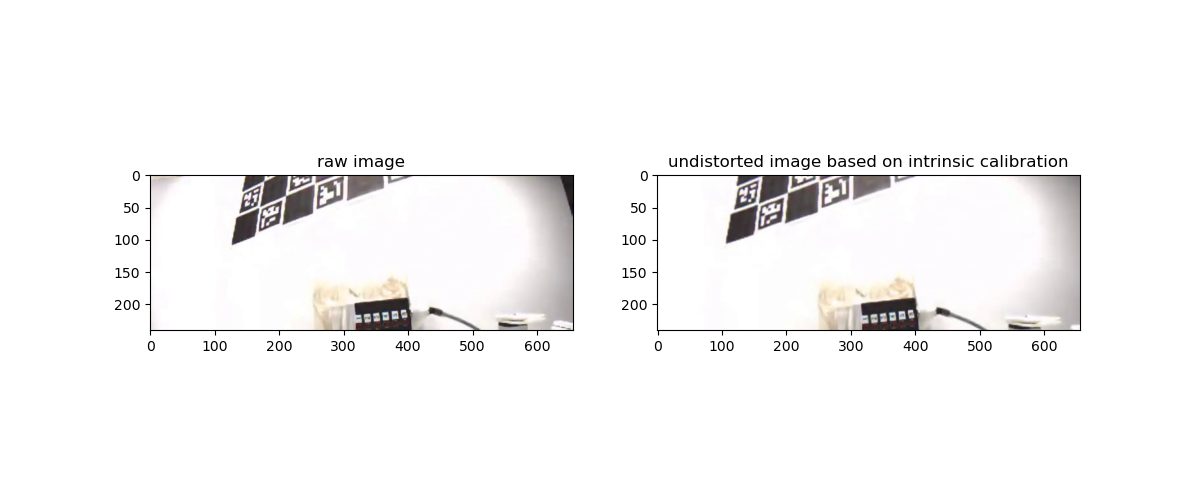

In [54]:
plt.close()
side2_cam.inspect_intrinsic_calibration(frame_idx = 380)

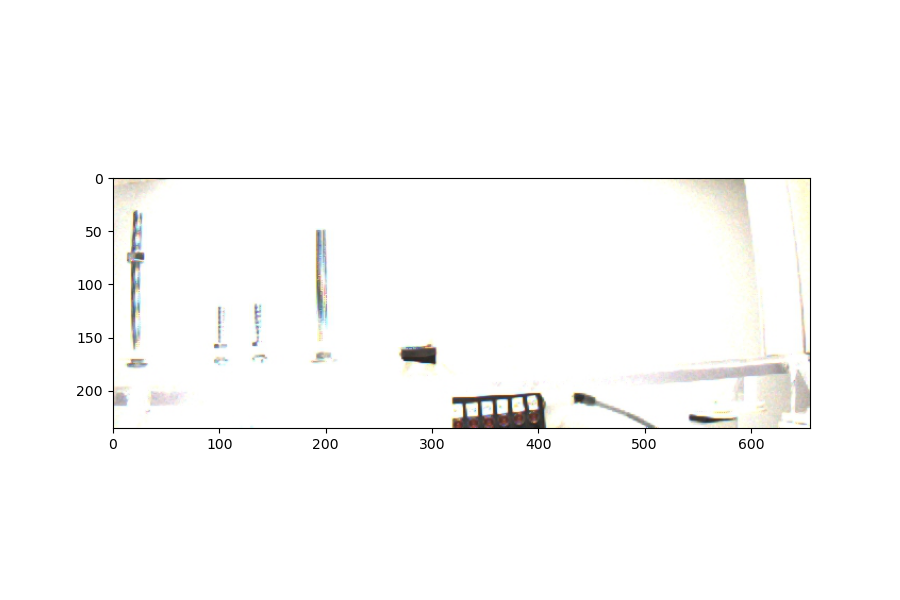

In [55]:
plt.close()
plot_single_frame_of_video(filepath='/mnt/c/Users/dsege/Downloads/220825/220825/220825_Side2_Positions.jpg', frame_idx=0)

In [56]:
side2_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 646, y_or_row_idx = 168, likelihood=0.999)
side2_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_right', x_or_column_idx = 614, y_or_row_idx = 168, likelihood=0.999)
side2_cam.add_manual_test_position_marker(marker_id = 'screw1_bottom', x_or_column_idx = 19, y_or_row_idx = 176, likelihood=0.999)
side2_cam.add_manual_test_position_marker(marker_id = 'screw1_nut', x_or_column_idx = 16, y_or_row_idx = 71, likelihood=0.999)
side2_cam.add_manual_test_position_marker(marker_id = 'screw1_top', x_or_column_idx = 22, y_or_row_idx = 31, likelihood=0.999)
side2_cam.add_manual_test_position_marker(marker_id = 'screw2_bottom', x_or_column_idx = 98, y_or_row_idx = 173, likelihood=0.999)
side2_cam.add_manual_test_position_marker(marker_id = 'screw2_top', x_or_column_idx = 99, y_or_row_idx = 121, likelihood=0.999)
side2_cam.add_manual_test_position_marker(marker_id = 'screw3_bottom', x_or_column_idx = 135, y_or_row_idx = 171, likelihood=0.999)
side2_cam.add_manual_test_position_marker(marker_id = 'screw3_top', x_or_column_idx = 133, y_or_row_idx = 119, likelihood=0.999)
side2_cam.add_manual_test_position_marker(marker_id = 'screw4_bottom', x_or_column_idx = 197, y_or_row_idx = 174, likelihood=0.999)
side2_cam.add_manual_test_position_marker(marker_id = 'screw4_top', x_or_column_idx = 194, y_or_row_idx = 50, likelihood=0.999)

In [57]:
side2_cam.save_manual_marker_coords_as_fake_dlc_output()

Your dataframe was successfully saved at: /mnt/c/Users/dsege/Downloads/220825/220825/Side2_manual_test_position_marker_fake.h5.
Your "fake DLC marker perdictions" were successfully loaded to the SingleCamDataForAnipose object!


In [58]:
side2_cam.test_position_markers_df

scorer    manually_annotated_marker_positions                  \
bodyparts             maze_corner_closed_left                   
coords                                      x    y likelihood   
0                                         646  168      0.999   

scorer                                                                 \
bodyparts maze_corner_closed_right                 screw1_bottom        
coords                           x    y likelihood             x    y   
0                              614  168      0.999            19  176   

scorer                           ...                                           \
bodyparts            screw1_nut  ... screw3_bottom screw3_top                   
coords    likelihood          x  ...    likelihood          x    y likelihood   
0              0.999         16  ...         0.999        133  119      0.999   

scorer                                                             
bodyparts screw4_bottom                 screw4_top                 
coords                x    y likelihood          x   y likelihood  
0                   197  174      0.999        194  50      0.999  

[1 rows x 33 columns]

Most likely, you will not be able to see all the test position markers from the individual camera FOV. Simply add those that you can see & eventually run the following method to validate them, which: a) adds those markers that are present in the test positions ground truth object but are missing in your current camera object with a likelihood of 0; and b) removes all marker ids that you added to your camera object, but are not present in the ground truth (to avoid typos, ..). Of course, you will be notified:

In [59]:
side2_cam.validate_test_position_marker_ids(test_positions_gt=test_positions)

The following marker_ids were missing and added to the dataframe with a likelihood of 0: ['maze_corner_open_left', 'maze_corner_open_right', 'x1', 'x2'].


In [60]:
side2_cam.test_position_markers_df

scorer    manually_annotated_marker_positions                  \
bodyparts             maze_corner_closed_left                   
coords                                      x    y likelihood   
0                                         646  168      0.999   

scorer                                                                 \
bodyparts maze_corner_closed_right                 screw1_bottom        
coords                           x    y likelihood             x    y   
0                              614  168      0.999            19  176   

scorer                           ...                        \
bodyparts            screw1_nut  ... maze_corner_open_left   
coords    likelihood          x  ...            likelihood   
0              0.999         16  ...                     0   

scorer                                                                 \
bodyparts maze_corner_open_right               x1               x2      
coords                         x  y likelihood  x  y likelihood  x  y   
0                              0  0          0  0  0          0  0  0   

scorer                
bodyparts             
coords    likelihood  
0                  0  

[1 rows x 45 columns]

### Ground1

In [43]:
filepath = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Ground1_cam_synchronized_for_calibration_all_parts.mp4')
ground1_cam = SingleCamDataForAnipose(cam_id = 'Ground1', filepath_synchronized_calibration_video = filepath)

Next, it makes sense to add all additional metadata about your camera, like the offset of the cropping indices that you noted during cropping in ICCapture & whether and how the video stream was flipped. If you did neither crop the video nor flip it, you can simply skip these functions and the default values (offsets = (0, 0) and both flippings = False) will be loaded automatically.

In [49]:
ground1_cam.add_cropping_offsets(x_or_column_offset=32, y_or_row_offset=44)
ground1_cam.add_flipping_details(flipped_horizontally=False, flipped_vertically=False)

Let´s stay with the properties of the camera also for the next step: the intrinsic camera calibration (see some explanation of what this is and why it is neccessary at the very top of this notebook). You can either run it (see the following cell - don´t worry, the calibration results will automatically be saved in the same directory where the checkerboard video is) ...

In [45]:
filepath_checkerboard_recording = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Checkerboard_Calibration/Ground1_checkerboard.mp4')
ground1_cam.run_intrinsic_camera_calibration(filepath_checkerboard_video=filepath_checkerboard_recording)

Frames with detected checkerboard: 1209.
Limited them to only 300.
User info: since no other information were provided, "degrees_rotated_clockwise" were set to the corresponding default values: 0.


... or load it from disk, if you have previously performed the calibration already:

In [50]:
filepath_intrinsic_calibration = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Checkerboard_Calibration/Ground1_checkerboard_intrinsic_calibration_results.p')
ground1_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = filepath_intrinsic_calibration)

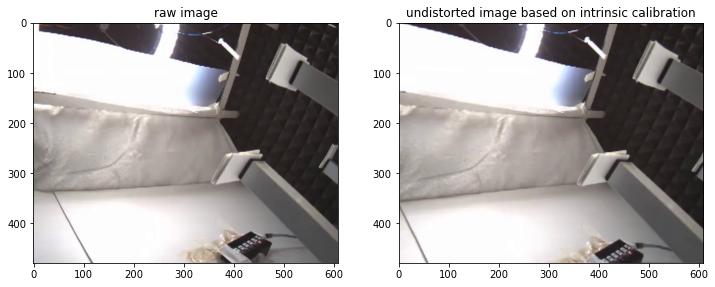

In [51]:
ground1_cam.inspect_intrinsic_calibration()

### Ground2

In [47]:
filepath = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Ground2_cam_synchronized_for_calibration_all_parts.mp4')
ground2_cam = SingleCamDataForAnipose(cam_id = 'Ground2', filepath_synchronized_calibration_video = filepath)

Next, it makes sense to add all additional metadata about your camera, like the offset of the cropping indices that you noted during cropping in ICCapture & whether and how the video stream was flipped. If you did neither crop the video nor flip it, you can simply skip these functions and the default values (offsets = (0, 0) and both flippings = False) will be loaded automatically.

In [52]:
ground2_cam.add_cropping_offsets(x_or_column_offset=0, y_or_row_offset=52)
ground2_cam.add_flipping_details(flipped_horizontally=False, flipped_vertically=False)

Let´s stay with the properties of the camera also for the next step: the intrinsic camera calibration (see some explanation of what this is and why it is neccessary at the very top of this notebook). You can either run it (see the following cell - don´t worry, the calibration results will automatically be saved in the same directory where the checkerboard video is) ...

In [53]:
filepath_checkerboard_recording = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Checkerboard_Calibration/Ground2_checkerboard.mp4')
ground2_cam.run_intrinsic_camera_calibration(filepath_checkerboard_video=filepath_checkerboard_recording)

Frames with detected checkerboard: 1210.
Limited them to only 300.
User info: since no other information were provided, "degrees_rotated_clockwise" were set to the corresponding default values: 0.


... or load it from disk, if you have previously performed the calibration already:

In [54]:
filepath_intrinsic_calibration = Path('/mnt/c/Users/dsege/Downloads/220825/220825/Checkerboard_Calibration/Ground2_checkerboard_intrinsic_calibration_results.p')
ground2_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration = filepath_intrinsic_calibration)

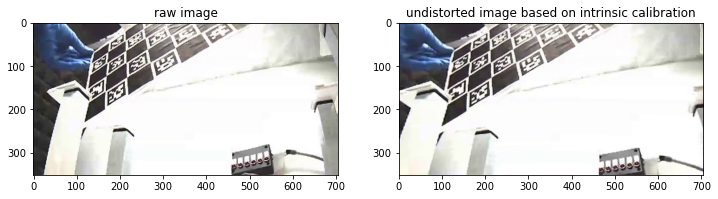

In [59]:
ground2_cam.inspect_intrinsic_calibration(frame_idx = 5600)

Draft Version:

## For each camera:

In [ ]:
bottom_cam = camera_calibration.SingleCamDataForAnipose(cam_id = 'bottom', filepath = Path('bums'))

In [ ]:
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 490, y_or_column_idx = 10)
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 490, y_or_column_idx = 10)
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 490, y_or_column_idx = 10)
bottom_cam.add_manual_test_position_marker(marker_id = 'maze_corner_closed_left', x_or_column_idx = 490, y_or_column_idx = 10)
bottom_cam.save_manual_marker_coords_as_fake_dlc_output()

# or:
bottom_cam.load_test_position_markers_df_from_dlc_prediction()

In [ ]:
bottom_cam.validate_test_position_marker_ids(test_positions_gt = test_positions)

In [ ]:
bottom_cam.run_intrinsic_camera_calibration(filepath_checkerboard_video, fisheye_cam = True, save, max_frame_count = 300)
# or:
bottom_cam.load_intrinsic_camera_calibration(filepath_intrinsic_calibration)

## Calibration for Anipose

In [ ]:
calibration_for_anipose = CalibrationForAnipose3DTracking(single_cams_to_calibrate = [bottom_cam, top_cam...])
calibration_for_anipose.run_calibration()
calibration_for_anipose.save(filepath)

In [ ]:
calibration_for_anipose.evaluate_triangulation_of_test_position_markers(test_positions_gt = test_positions)